In [54]:
import os
import sys
import requests

import mercury
from dotenv import load_dotenv

import networkx as nx
from netgraph import Graph, InteractiveGraph
from ipysigma import Sigma
from pyvis.network import Network

import pandas as pd
from pandas import json_normalize

import matplotlib
import matplotlib.pyplot as plt

import itertools

import xmltodict

In [3]:
# Load app for json display
mercury.App(title="Display JSON", static_notebook=True)

# Load server environment
load_dotenv(os.path.dirname(sys.path[1]) + '/server/.env')

mercury.App

True

# 🗄️ Data

In [4]:
# API search info
OPENALEX_API_URL = os.environ.get('OPENALEX_API_URL')

## Structure

Get single entry

In [6]:
# Request answer
json_answer = requests.get(OPENALEX_API_URL).json()

Display answer

In [7]:
# Display json
mercury.JSON(json_answer)

## Requests

Search by keywords

In [22]:
def url_thematic(url:str, thematic: list[str], per_page:int=100) -> str:
    """
    This function create the URL string with the theme of the query and the cursor
    to get all the available pages on OpenAlex
    :param thematic: theme(s) you are interested in
    :return: URL string
    """
    if thematic:
        thematic = ' AND '.join(thematic)
        url = url+',' if url[-1] != ',' else url
        url += f"title.search:{thematic},abstract.search:{thematic}&mailto=bso@recherche.gouv.fr&cursor=*&per_page={per_page}"

    return url

In [23]:
# Keywords list (AND)
keywords = ['video games', 'artificial intelligence']

# Search url
request_url = url_thematic(OPENALEX_API_URL, keywords)
print(request_url)

# Request answer
json_answer = requests.get(request_url).json()

https://api.openalex.org/works?filter=publication_year:2018-,title.search:video games AND artificial intelligence,abstract.search:video games AND artificial intelligence&mailto=bso@recherche.gouv.fr&cursor=*&per_page=100


Display answer

In [12]:
# Display json
mercury.JSON(json_answer)

Search by orcid

In [16]:
def url_orcid(url:str, orcids:list[str], per_page:int=100) -> str:
    """
    This function create the URL string with the orcid of authors and the cursor
    to get all the available pages on OpenAlex
    :param orcids: author(s) (orcid) you are interested in
    :return: URL string
    """
    if orcids:
        orcids = ' AND '.join(orcids)
        url = url+',' if url[-1] != ',' else url
        url += f"author.orcid:{orcids}&mailto=bso@recherche.gouv.fr&cursor=*&per_page={per_page}"

    return url

In [17]:
# author id list
orcids = ["0000-0003-2197-515X"]

# Search url
request_url = url_orcid(OPENALEX_API_URL, orcids)
print(request_url)

# Request answer
json_answer = requests.get(request_url).json()

https://api.openalex.org/works?filter=publication_year:2018-,author.orcid:0000-0003-2197-515X&mailto=bso@recherche.gouv.fr&cursor=*&per_page=100


Display answer

In [18]:
# Display json
mercury.JSON(json_answer)

In [102]:
def idref_json_get(idref:str) -> str:
    """Use idref api to get author json info

    Args:
        idref: author idref

    Returns:
        author json data
    """
    idref_url = f'https://www.idref.fr/{idref}.xml'
    idref_xml = requests.get(idref_url).text
    idref_json = xmltodict.parse(idref_xml)
    return idref_json


def idref_json_find_orcid(idref_json:str) -> str:
    """This function check author idref data and try to find an ORCID.
    Returns None if no ORCID found.

    Args:
        idref_json: author json data

    Returns:
        ORCID
    """
    orcid = None
    found = False
    idref_data = idref_json['record']['datafield']

    for subid in range(len(idref_data)):
        subfield = idref_data[subid]['subfield']
    
        if not isinstance(subfield, list):
            continue

        for elem in subfield:
            if isinstance(elem, dict):
                elem = elem.get('#text') # if xml parser
            if elem == 'ORCID':
                found = True
                break

        if found:
            for elem in subfield:
                if isinstance(elem, dict):
                    elem = elem.get('#text') # if xml parser
                if type(elem) is str and len(elem) == 19: # @todo: check format better
                    orcid = elem
                    break

        if orcid:
            break

    return orcid

# 🌐 Network

## Structure

* Nodes = authors
* Edges = (co)publications

## Creation

Clean answer and create graph

In [47]:
# Filter params
NB_MAX_COAUTHORS = 20
NB_MIN_PUBLICATIONS = 5

# Init arrays
fullNameIdref = {}
topicWikidata = {}
all_edges = {}
nb_pub_removed = 0
nb_aut_removed = 0

# Create graph
G = nx.Graph()

# Filter data
# 1. Loop over answers
for hit in json_answer['hits']['hits']:
    elt = hit['_source']
    authors = elt.get('authors')

    # 2. Loop over authors and remove publication if too many coauthors
    if len(authors) > NB_MAX_COAUTHORS:
        print('{}: removing publication ({} authors)'.format(hit['_source']['id'], len(authors)))
        nb_pub_removed += 1
        continue
    
    # 3. Define a node for each author if fullname exists
    currentNodes = []
    for aut in elt.get('authors'):
        if 'person' in aut:
            idref = aut['person']['id']
            if idref not in fullNameIdref:
                fullNameIdref[idref] = aut['fullName']
            currentNode = fullNameIdref[idref]
        elif 'fullName' in aut:
            currentNode = aut['fullName']
        else:
            continue
        currentNodes.append(currentNode)
    
    # 4. Update nodes informations
    for node in currentNodes:
        # Add node or increment publication number
        if node not in all_edges:
            all_edges[node] = {'nb_publis': 0, 'coauthors':{}, 'topics': {}}
        all_edges[node]['nb_publis'] += 1
        # Compute number of coauthors
        for node_ in currentNodes:
            if node != node_ :
                if node_ not in  all_edges[node]['coauthors']:
                    all_edges[node]['coauthors'][node_] = 0
                all_edges[node]['coauthors'][node_] += 1
        # Get wikidata
        if elt.get('domains') is None : continue
        for topic in elt.get('domains'):
            if 'code' in topic:
                code = topic.get('code')
                if code not in topicWikidata:
                    topicWikidata[code] = topic.get('label').get('default').lower()
                label = topicWikidata[code]
                if label not in all_edges[node]['topics']:
                    all_edges[node]['topics'][label] = 0
                all_edges[node]['topics'][label] += 1
                
# 5. Add nodes to graph object       
for n in all_edges:
    # Filter by number of publications
    if all_edges[n]['nb_publis'] < NB_MIN_PUBLICATIONS:
        nb_aut_removed += 1
        continue
    # Add nodes
    G.add_node(n, size = all_edges[n]['nb_publis'])
    # Add weights (number of co publications)
    for m in all_edges[n]['coauthors']:
        G.add_edge(n, m, weight = all_edges[n]['coauthors'][m])

print('\nNumber of publications :', len(json_answer['hits']['hits']))
print('Number of publications removed (too many coauthors) :', nb_pub_removed)
print('Number of authors removed (too few publications) :', nb_aut_removed)
print('\nGraph - number of nodes (authors) :', G.number_of_nodes())
print('Graph - number of edges (copublications) :', G.number_of_edges())


sudoc266814352: removing publication (25 authors)

Number of publications : 672
Number of publications removed (too many coauthors) : 1
Number of authors removed (too few publications) : 1179

Graph - number of nodes (authors) : 260
Graph - number of edges (copublications) : 337


# 👥 Communities

## Structure

* Communities = lists of nodes

## Models

* Louvain
* Girvan-Newman
* CPM
* BigClam
* Graph Neural Network

## Creation

Use Louvain algorithm (networkx)

In [37]:
# Networkx louvain algo
lv_communities = nx.community.louvain_communities(G, seed=42)
lv_dict = {n:c for c in range(len(lv_communities)) for n in lv_communities[c]}

# Add communities to graph element
# for n in G.nodes():
#     G.nodes[n]['label'] = lv_dict.get(n)

print("Number of communities found :", len(lv_communities))

Number of communities found : 20


Use Girvan-Newman algorithm (networkx)

In [75]:
# Networkx girvan newman algo
# k = 15
# limited = itertools.takewhile(lambda c: len(c) <= k, nx.community.girvan_newman(G))
# for communities in limited:
#     print(communities)
#     gn_communities = tuple(sorted(c) for c in communities)




communities = list(nx.community.girvan_newman(G))
modularities = [nx.community.modularity(G, communities[k]) for k in range(len(communities))]
max_modularity = max(modularities)
max_modularity_idx = modularities.index(max_modularity)

print(f"Best modularity : {max_modularity} (k={max_modularity_idx+1})")

gn_communities = communities[max_modularity_idx]
gn_dict = {n:c for c in range(len(gn_communities)) for n in gn_communities[c]}

print("Number of communities found :", len(gn_communities))

Best modularity : 0.7351910399027359 (k=6)
Number of communities found : 19


Use k-clique (CPM) algorithm (networkx)

In [69]:
# Networkx k clique algo
cliques = list(nx.community.k_clique_communities(G, 3))
kc_communities = [list(c) for c in cliques]
kc_dict = {n:c for c in range(len(kc_communities)) for n in kc_communities[c]}

print("Number of communities found :", len(kc_communities))

Number of communities found : 5


## Analysis

Communities best topics

In [40]:
# Store all communities topics
communities_topics = {}
for author, community in lv_dict.items():
    if community not in communities_topics:
        communities_topics[community] = {'topics': {}}
    for topic, weight in all_edges[author]['topics'].items():
        if topic not in communities_topics[community]['topics']:
            communities_topics[community]['topics'][topic] = 0
        communities_topics[community]['topics'][topic] += weight

In [41]:
# Get top 5 topics for each community
for c in range(len(communities_topics)):
    topics = communities_topics[c]['topics']
    top = sorted(topics, key=topics.get, reverse=True)[:5]
    print(f"Community {c} :")
    print(top, '\n')

Community 0 :
['jeux vidéos', 'jeux vidéo', 'langage politique', 'presse politique', 'hommes politiques'] 

Community 1 :
['jeux vidéos', 'jeux vidéo', 'interaction homme-ordinateur', 'traduction', 'joueurs de jeux vidéo'] 

Community 2 :
['anthropomorphisme', 'réalité virtuelle', 'socialisation', 'jeux vidéo', 'jeux vidéos'] 

Community 3 :
['jeux vidéos', 'jeux vidéo', 'transmédia', 'horreur', 'genre'] 

Community 4 :
['jeux vidéos', 'sujet (psychologie)', 'symbolisme -- aspect psychologique', 'psychopathologie transgénérationnelle', 'mutisme électif'] 

Community 5 :
['jeux vidéos', 'performance artistique', 'espace public', 'video games', 'sound design'] 

Community 6 :
['jeux vidéos', 'avatar', 'assassin’s creed', 'ordinateur', 'stéréotypes de genre'] 

Community 7 :
['mythes nordiques', 'intermédialité', 'assassin’s creed valhalla', 'franchise', 'transmédia'] 

Community 8 :
['antiquité', 'jeux vidéos', 'gameplay', 'rome', 'unités militaires'] 

Community 9 :
['jeux vidéos', 'int

# 🖼️ Visualisation

## Matplotlib

Display network

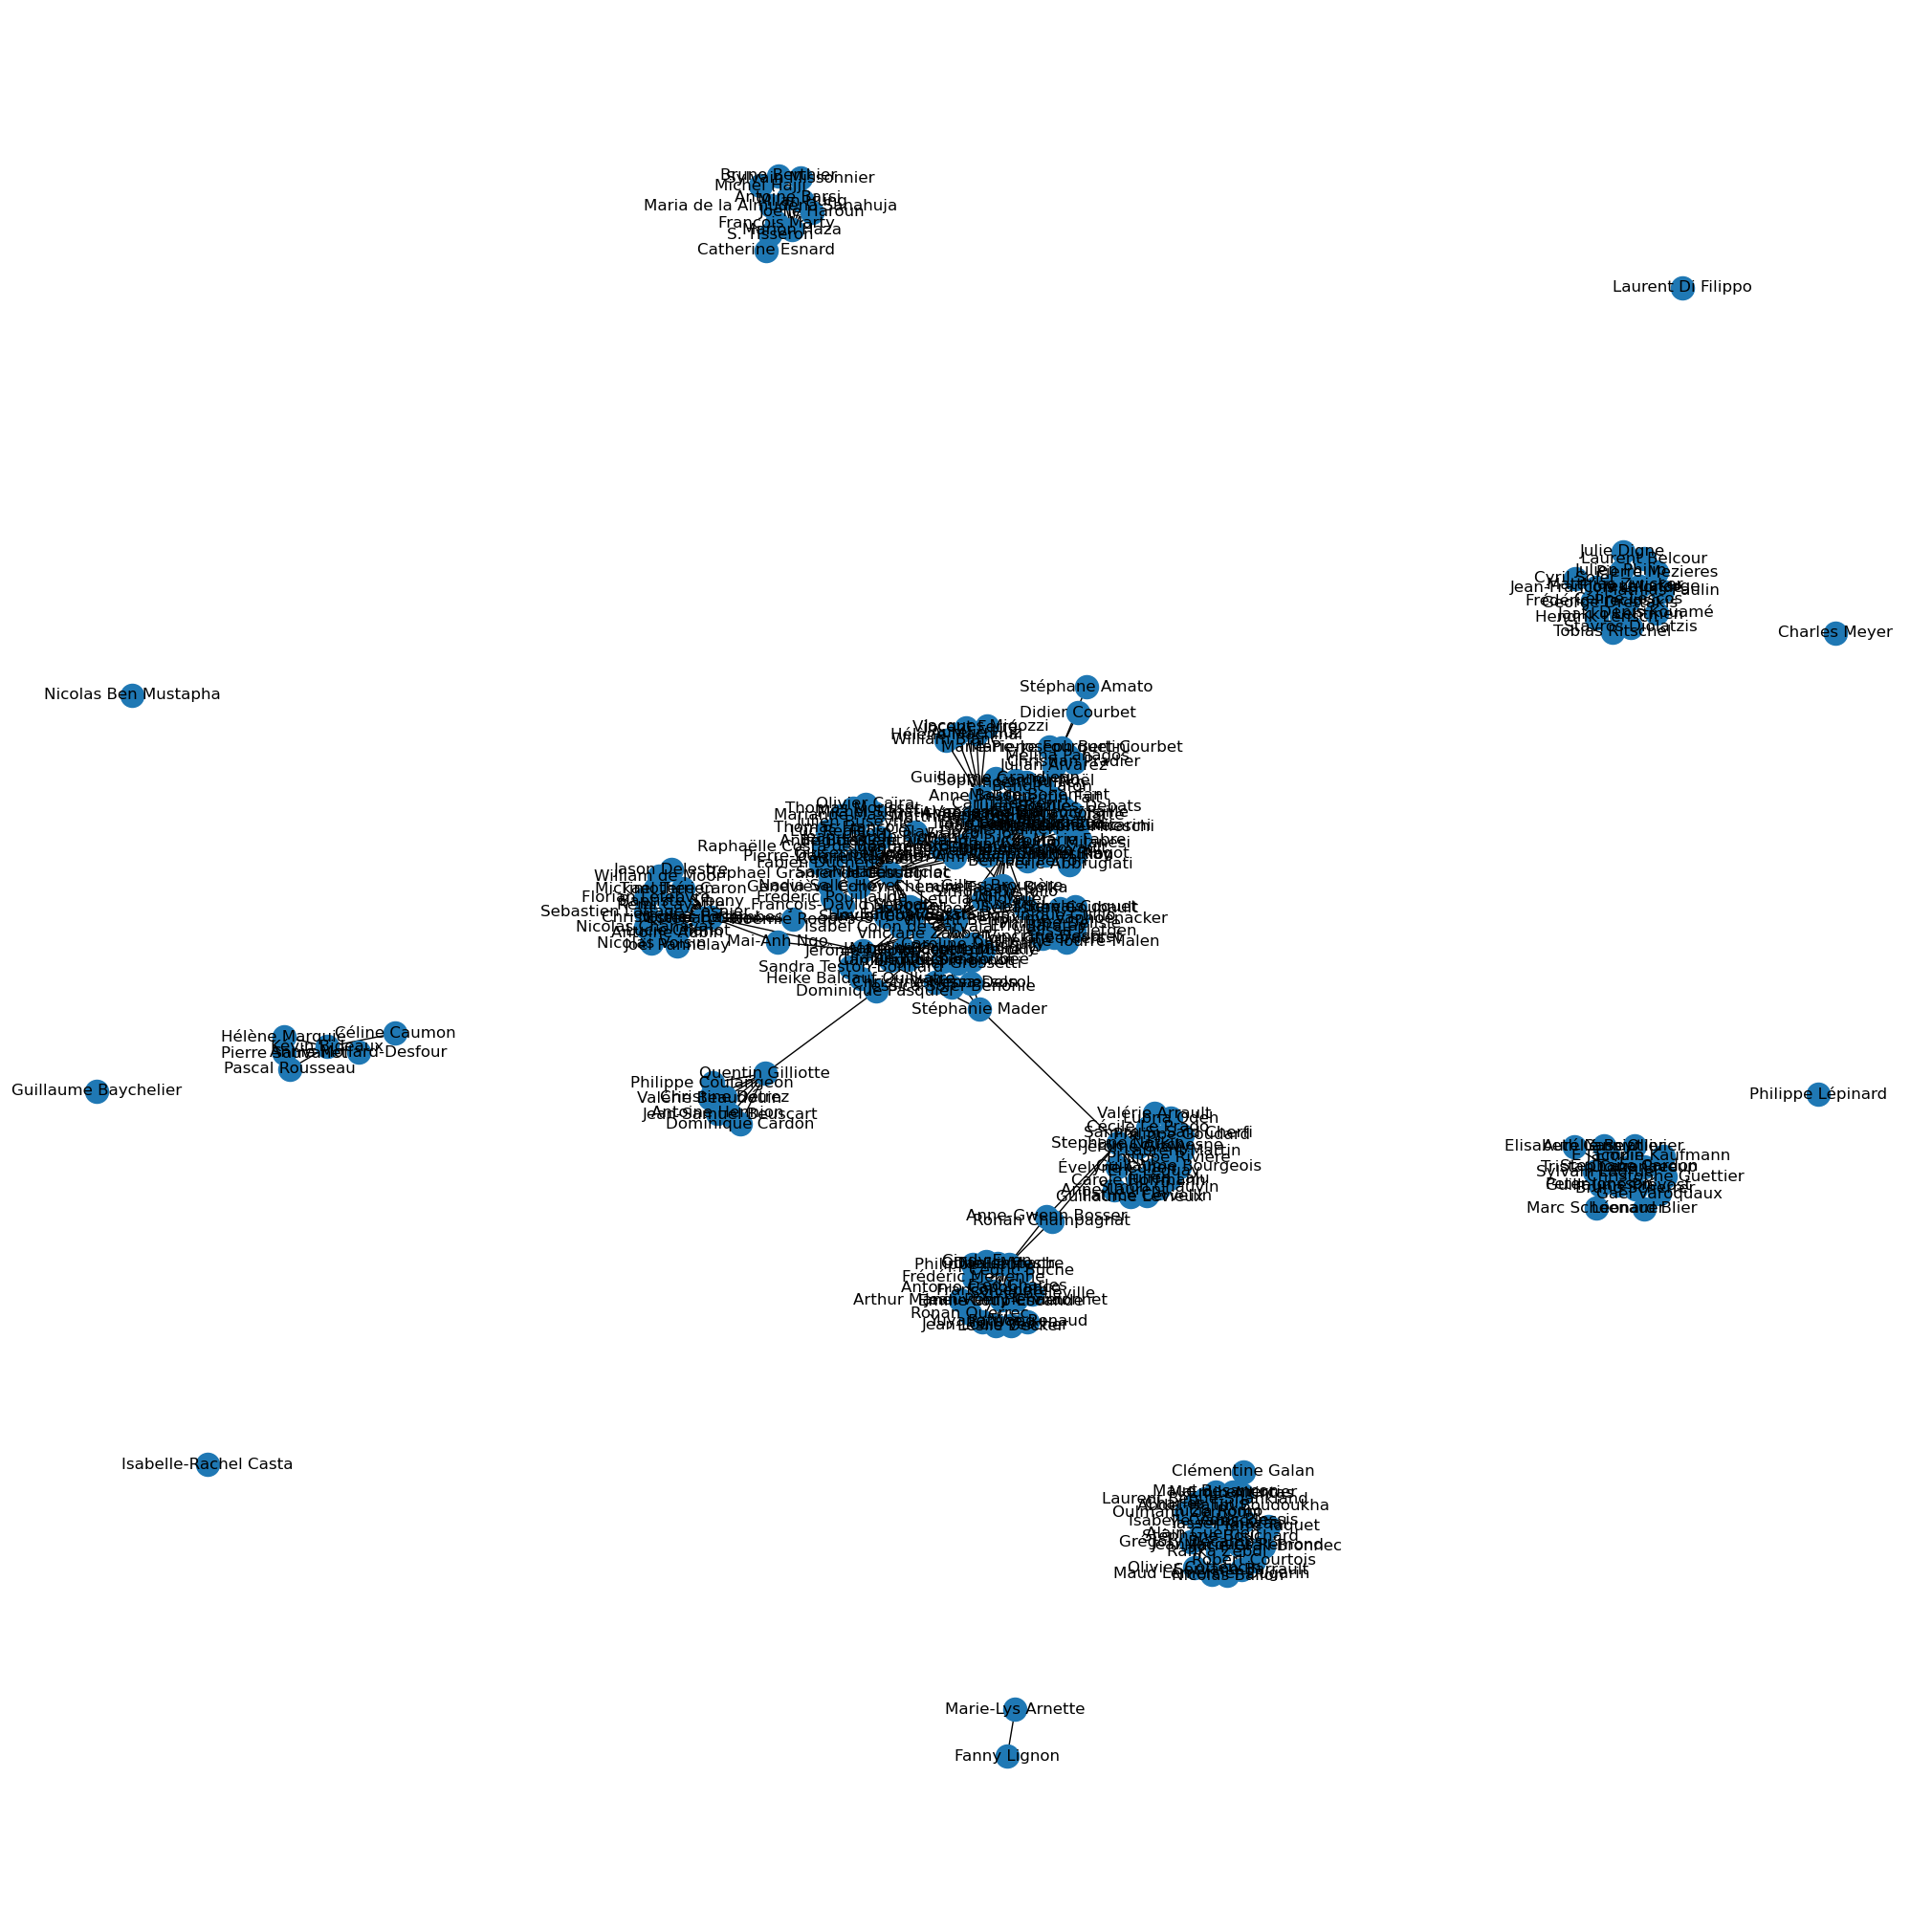

In [42]:
# Draw network
plt.figure(figsize=(20,20))
nx.draw(G, pos=nx.spring_layout(G), with_labels = True)
plt.draw()

Display Louvain communities

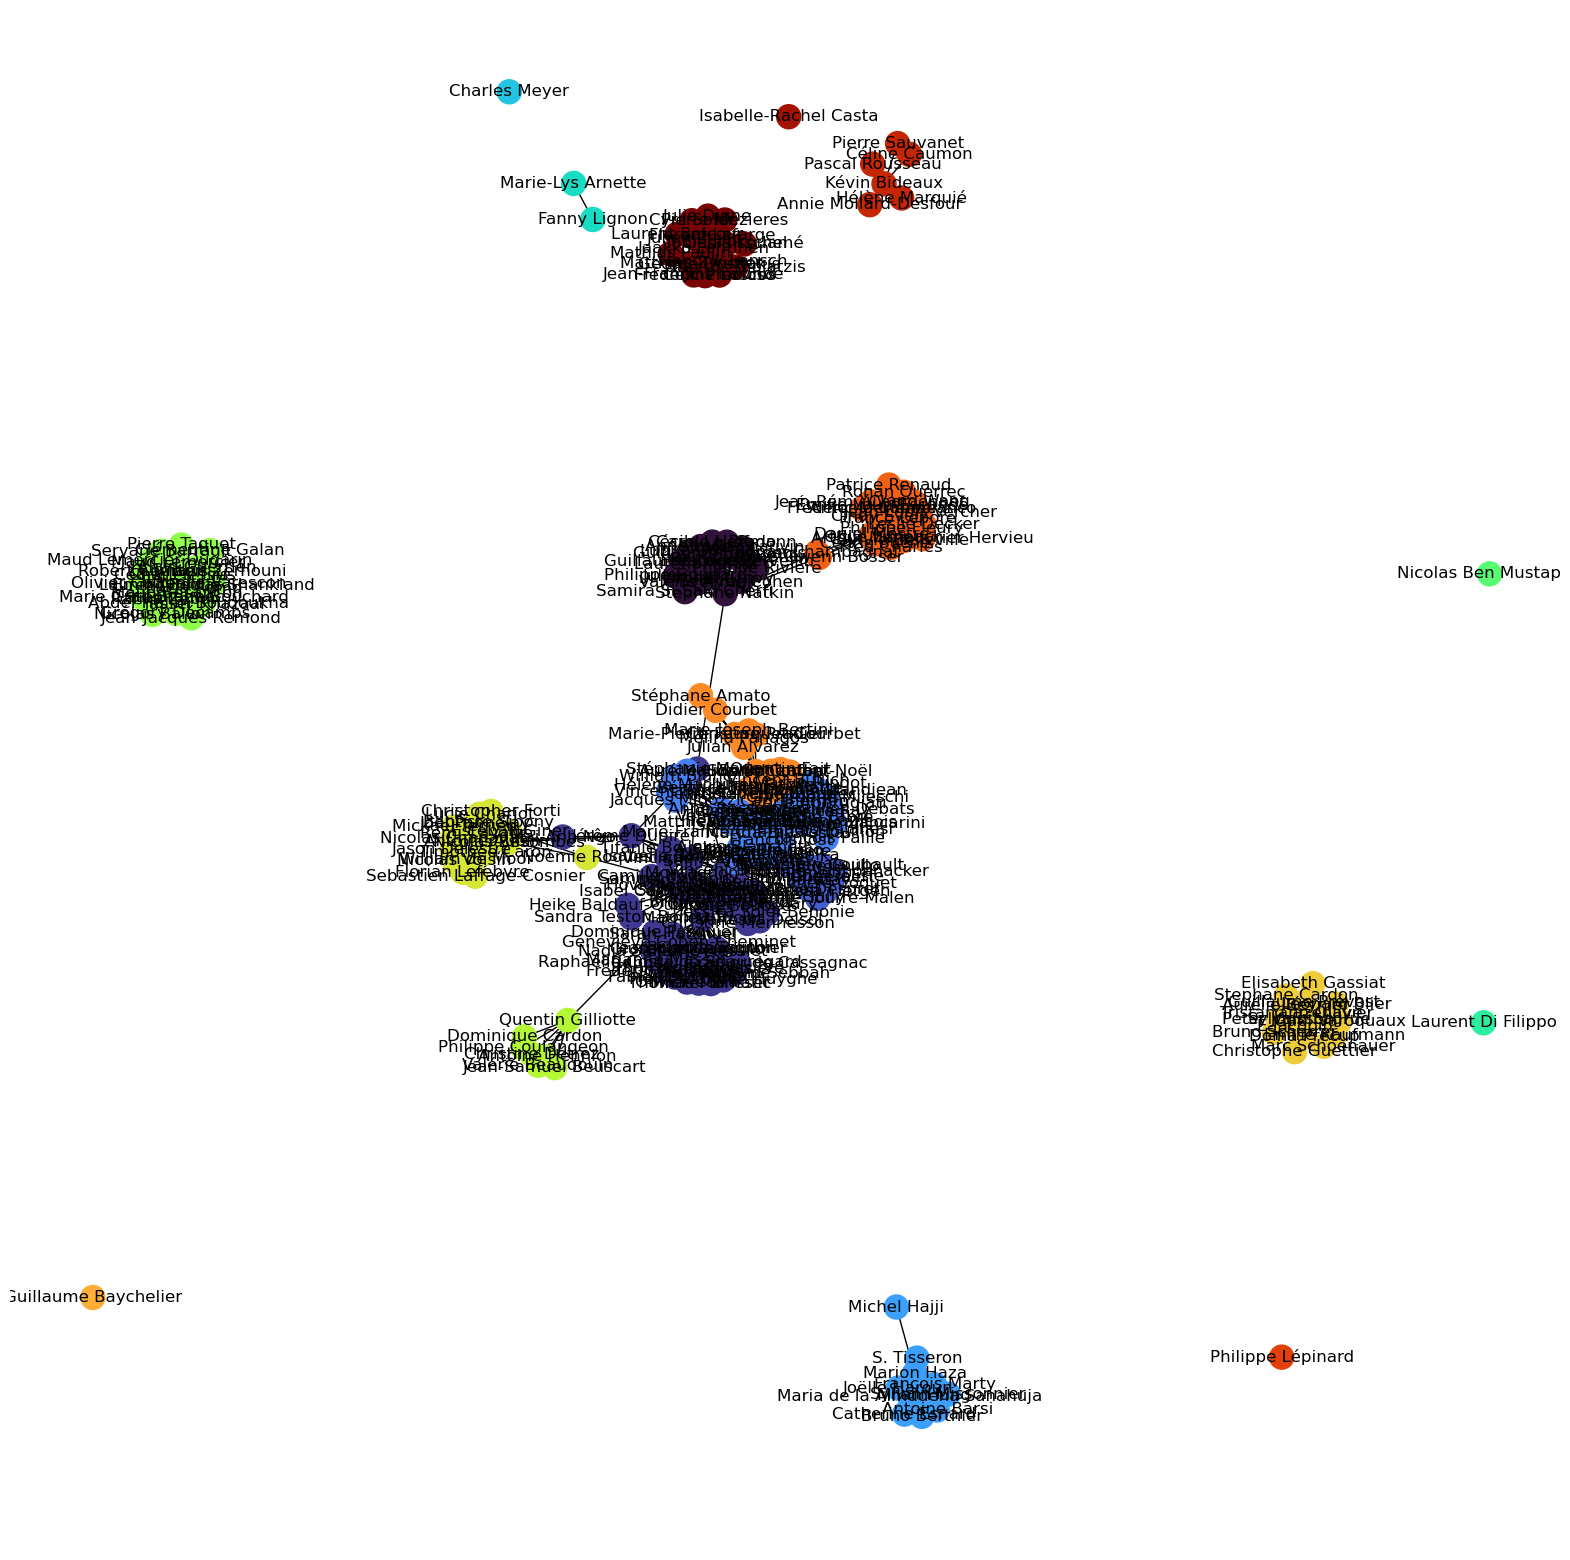

In [43]:
# Color communities
cmap = matplotlib.colormaps['turbo'].resampled(len(lv_communities))

# Draw network
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, cmap=cmap, nodelist=lv_dict.keys(), node_color=list(lv_dict.values()))
plt.axis('off')
plt.draw()

Display Girvan-Newman communities

NetworkXError: Node 'Audrey Steinberger' has no position.

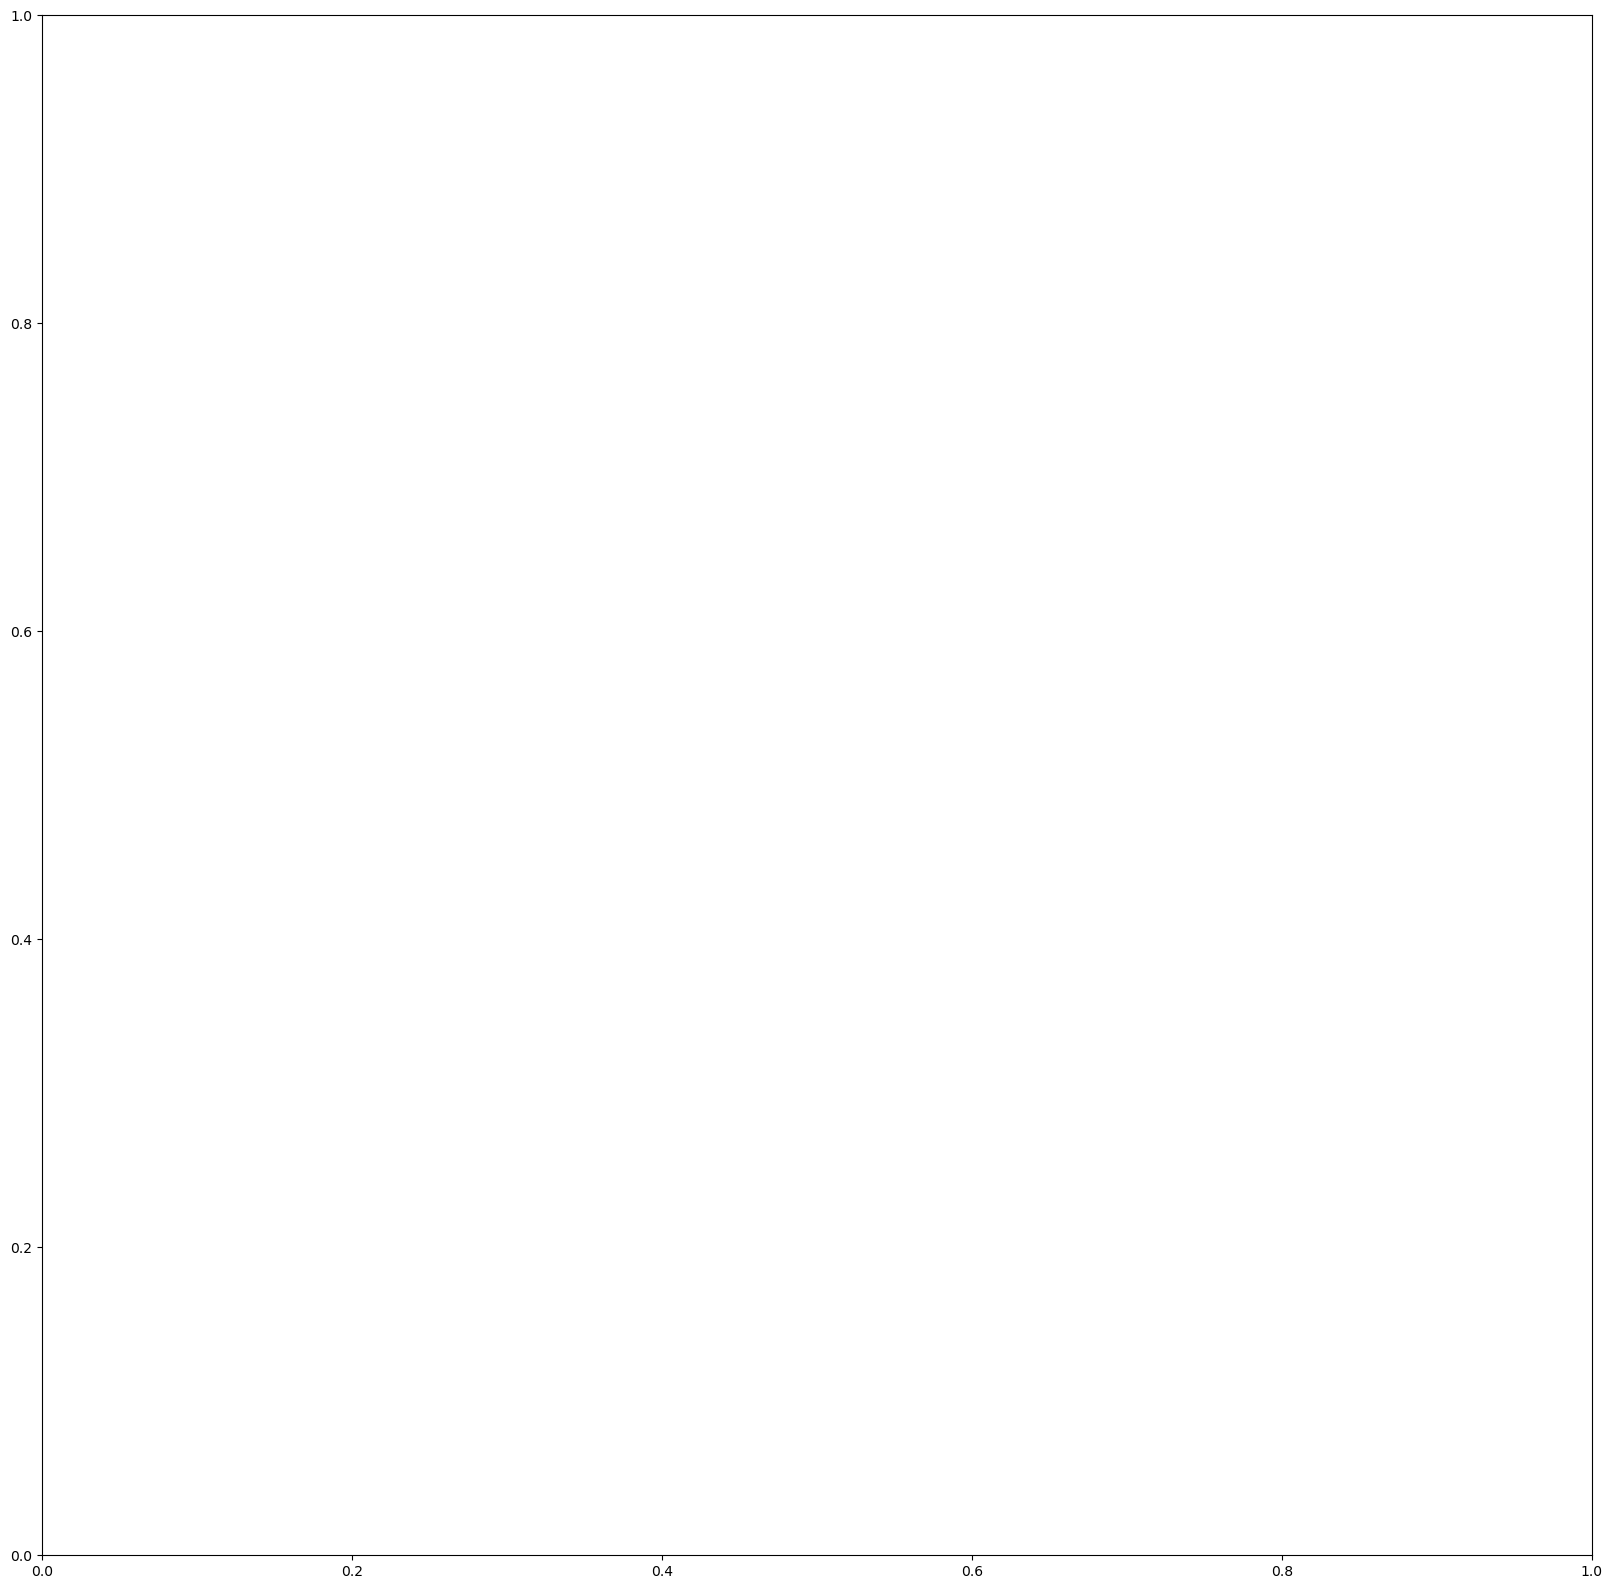

In [44]:
# Color communities
cmap = matplotlib.colormaps['turbo'].resampled(len(gn_communities))

# Draw network
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, cmap=cmap, nodelist=gn_dict.keys(), node_color=list(gn_dict.values()))
plt.axis('off')
plt.draw()

Display k-clique communities

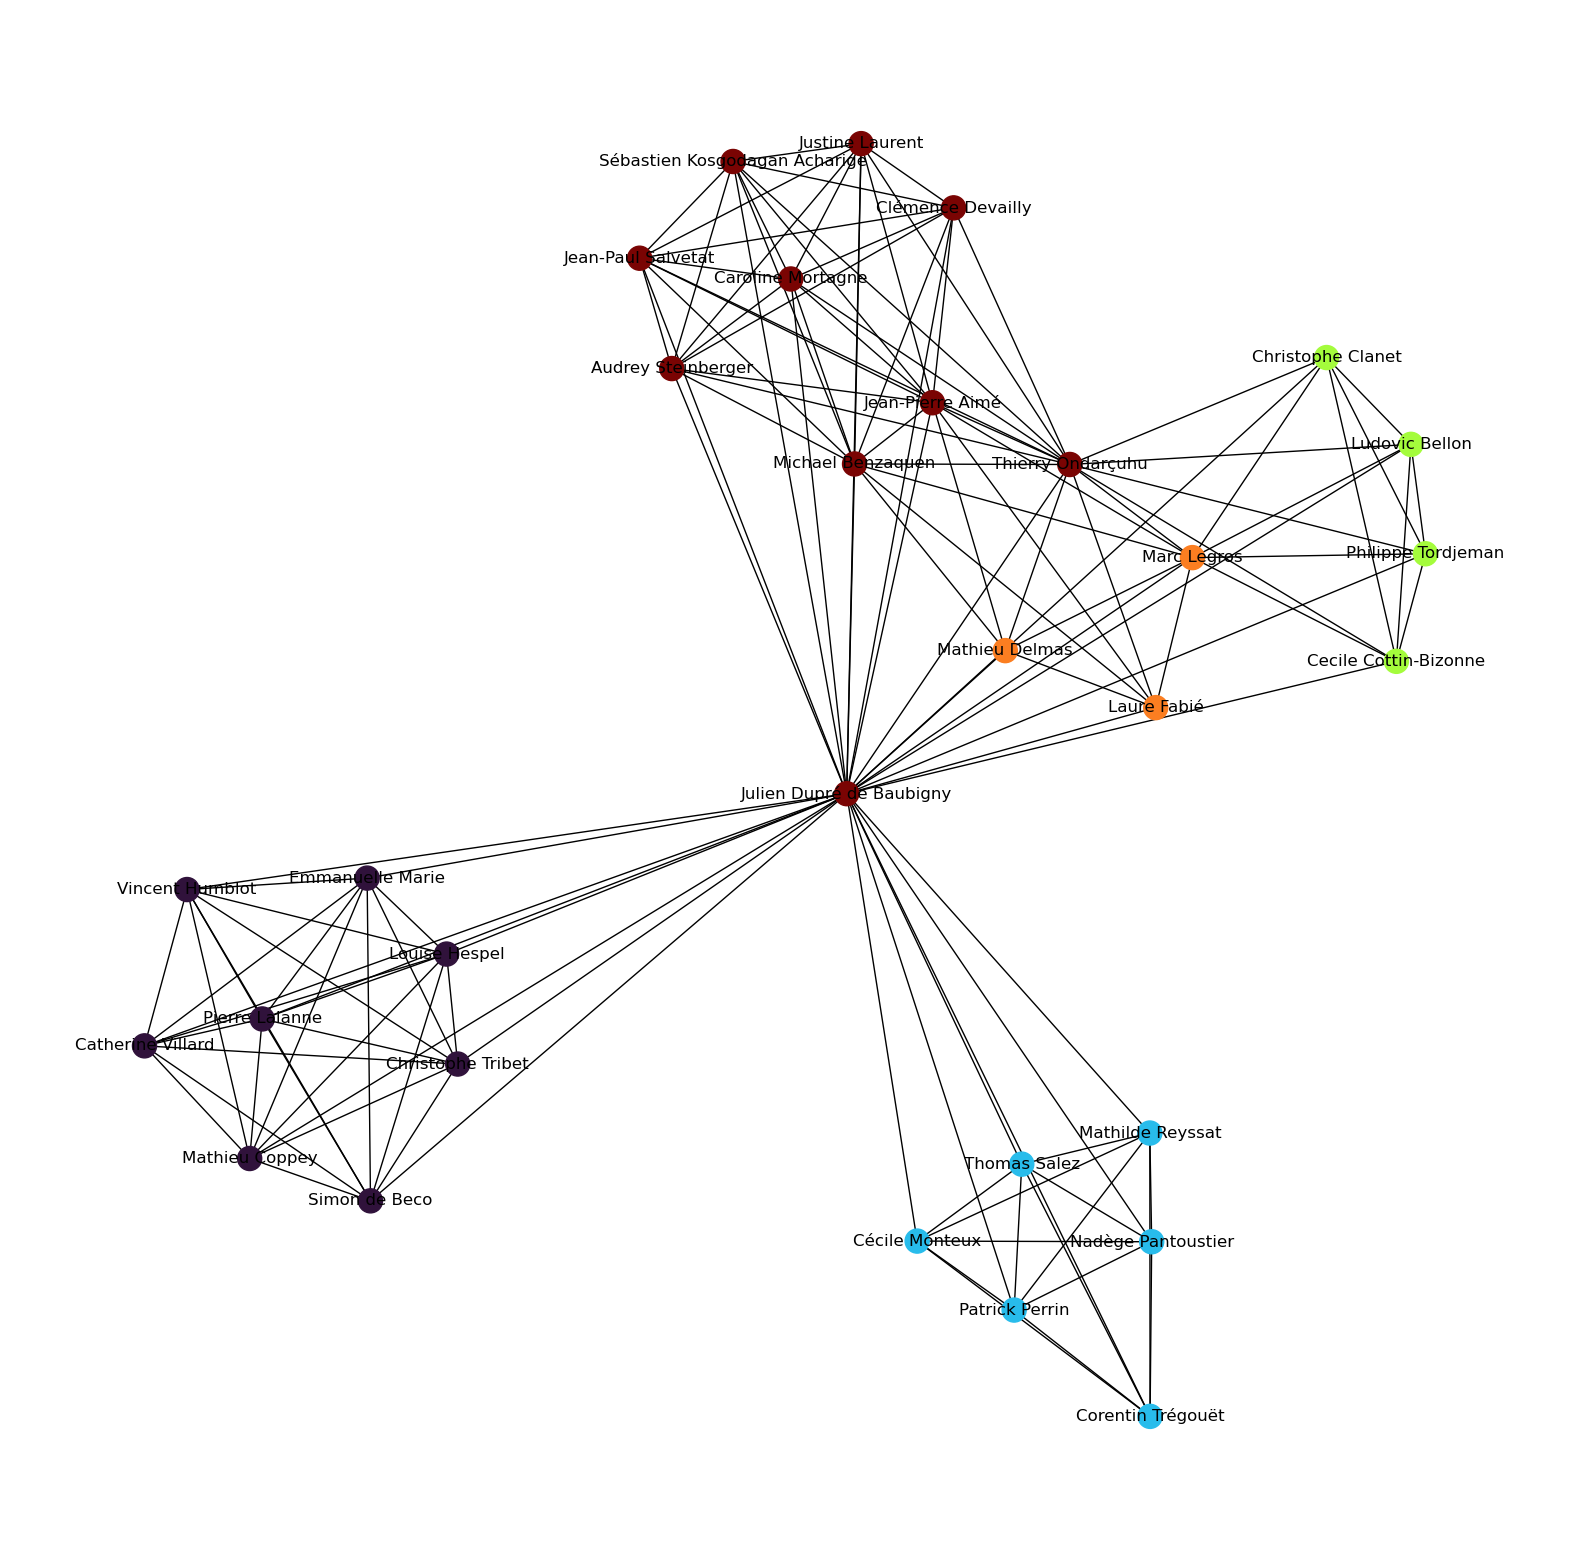

In [ ]:
# Color communities
cmap = matplotlib.colormaps['turbo'].resampled(len(kc_communities))

# Draw network
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, cmap=cmap, nodelist=kc_dict.keys(), node_color=list(kc_dict.values()))
plt.axis('off')
plt.draw()

## Netgraph

Display network

/Users/victor/miniconda3/envs/mesr/lib/python3.11/site-packages/netgraph/_utils.py:360: RuntimeWarning: invalid value encountered in divide
  v = v / np.linalg.norm(v, axis=-1)[:, None] # unit vector


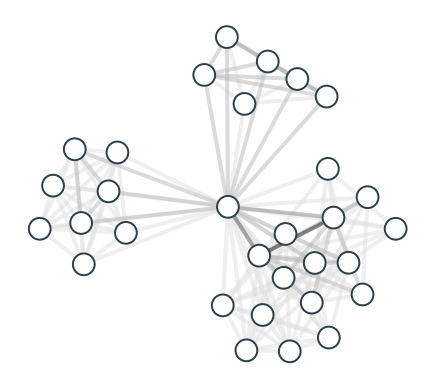

In [ ]:
# Draw non interactive network
Graph(G, node_layout='spring')
plt.show()

Display Louvain communities

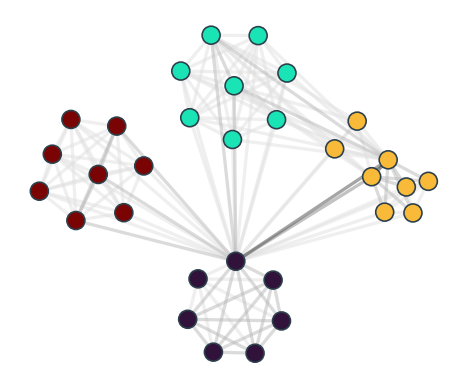

In [ ]:
# Color communities
cmap = matplotlib.colormaps['turbo'].resampled(len(lv_communities))
community_to_color = {c: list(cmap(c)) for c in range(len(lv_communities))}
node_color = {n: community_to_color[c] for n, c in lv_dict.items()}


# Draw non interactive communities
Graph(G, node_color=node_color, node_layout='community', 
      node_layout_kwargs=dict(node_to_community=lv_dict)
)

Display Girvan-Newman communities

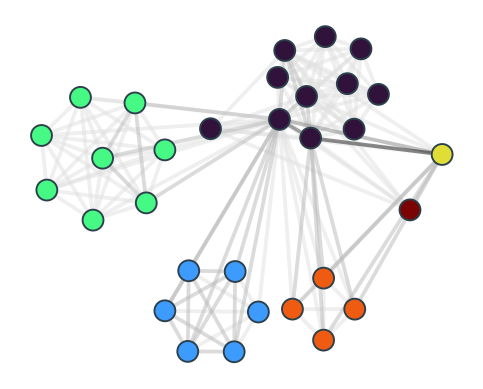

In [ ]:
# Color communities
cmap = matplotlib.colormaps['turbo'].resampled(len(gn_communities))
community_to_color = {c: list(cmap(c)) for c in range(len(gn_communities))}
node_color = {n: community_to_color[c] for n, c in gn_dict.items()}


# Draw non interactive communities
Graph(G, node_color=node_color, node_layout='community', 
      node_layout_kwargs=dict(node_to_community=gn_dict)
)

## Pyvis

Write pyvis html file

In [ ]:
# Color communities
cmap = matplotlib.colormaps['turbo'].resampled(len(lv_communities))
community_to_color = {c: list(cmap(c)) for c in range(len(lv_communities))}
# node_color = {n:c for n, c in lv_dict.items()}
nx.set_node_attributes(G, lv_dict, 'group')

# Pyvis network
net = Network()
net.toggle_physics(False)
net.from_nx(G)
net.write_html('nx2.html')

## Sigma.js

Display network

In [78]:
# Use sigma widget
Sigma(G, node_size=G.degree, node_color='category')

Sigma(nx.Graph with 260 nodes and 337 edges)

Display Louvain communities

In [ ]:
# Color communities
cmap = matplotlib.colormaps['turbo'].resampled(len(lv_communities))
community_to_color = {c: list(cmap(c)) for c in range(len(lv_communities))}
node_color = {n:c for n, c in lv_dict.items()}

# Sigma visualization
Sigma(G, node_size=G.degree, node_color=node_color)

Sigma(nx.Graph with 31 nodes and 135 edges)

Display Girvan-Newman communities

In [76]:
# Color communities
cmap = matplotlib.colormaps['turbo'].resampled(len(gn_communities))
community_to_color = {c: list(cmap(c)) for c in range(len(gn_communities))}
node_color = {n:c for n, c in gn_dict.items()}

# Sigma visualization
Sigma(G, node_size=G.degree, node_color=node_color)

Sigma(nx.Graph with 260 nodes and 337 edges)

Display k-clique communities

In [ ]:
# Color communities
cmap = matplotlib.colormaps['turbo'].resampled(len(kc_communities))
community_to_color = {c: list(cmap(c)) for c in range(len(kc_communities))}
node_color = {n:c for n, c in kc_dict.items()}

# Sigma visualization
Sigma(G, node_size=G.degree, node_color=node_color)

Sigma(nx.Graph with 31 nodes and 135 edges)